In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from string import punctuation
from os import listdir
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from numpy import array
from pickle import dump, load
from summa import keywords

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Flatten, Dropout, Embedding, Conv1D, MaxPooling1D, concatenate, Attention, Lambda
from keras import backend as K


## Evaluate Model 

In [2]:
# load a clean dataset
def load_dataset(filename):
	return load(open(filename, 'rb'))

In [3]:
# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

In [4]:
# calculate the maximum document length
def max_length(lines):
	return max([len(s.split()) for s in lines])

In [5]:
# encode a list of lines
def encode_text(tokenizer, lines, length):
	# integer encode
	encoded = tokenizer.texts_to_sequences(lines)
	# pad encoded sequences
	padded = pad_sequences(encoded, maxlen=length, padding='post')
	return padded

In [6]:
# load datasets
trainLines, trainLabels = load_dataset('../Dataset/train.pkl')
testLines, testLabels = load_dataset('../Dataset/test.pkl')

In [7]:
# create tokenizer
tokenizer = create_tokenizer(trainLines)
# calculate max document length
length = max_length(trainLines)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX = encode_text(tokenizer, trainLines, length)
testX = encode_text(tokenizer, testLines, length)
print(testX.shape,testX.shape)

Max document length: 3158
Vocabulary size: 11931
(2223, 3158) (2223, 3158)


In [8]:
model = load_model('../Models/LSTM.h5')

In [9]:
pd.set_option('display.max_colwidth', None)

In [10]:
predictions, attention_weights = model.predict(testX)

In [11]:
attention_weights = attention_weights[:100]
test_sequences = tokenizer.sequences_to_texts(testX[:100])

In [12]:
predicted_labels = np.zeros(len(predictions), dtype=int)
for i in range(len(predictions)):
    predicted_labels[i] = np.argmax(predictions[i])
    

## Classification Evaluation

In [13]:
def evaluate_classification(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels) * 100
    precision = precision_score(true_labels, predicted_labels, average='macro') * 100
    recall = recall_score(true_labels, predicted_labels, average='macro') * 100
    f1 = f1_score(true_labels, predicted_labels, average='macro') * 100
    
    return accuracy, precision, recall, f1

In [14]:
def plot_confusion_matrix(true_labels, predicted_labels, labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [15]:
accuracy, precision, recall, f1 = evaluate_classification(testLabels, predicted_labels)

print("Accuracy:", accuracy , "%")
print("Precision:", precision, "%")
print("Recall:", recall, "%")
print("F1 Score:", f1, "%")

Accuracy: 86.77462887989203 %
Precision: 83.63518852401639 %
Recall: 80.80902388577279 %
F1 Score: 82.1325180064771 %


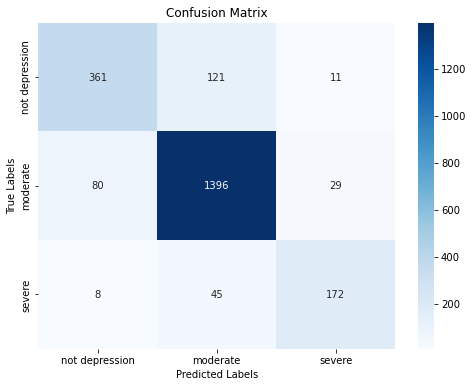

In [16]:
class_labels = ['not depression', 'moderate', 'severe']

plot_confusion_matrix(testLabels, predicted_labels, class_labels)

##  Justification for Classification

### Extract Keywords

In [17]:
from summa import keywords

def extract_keywords(text):
    extracted_keywords = keywords.keywords(text, ratio=0.5, scores=True, language="english")
    sorted_keywords = sorted(extracted_keywords, key=lambda x: x[1], reverse=True)
    keywordslist = [f"{str(keyword[0])} ({str(keyword[1])})" for keyword in sorted_keywords]
    return keywordslist


In [18]:
def get_sentences_with_highest_weights(input_text, attention_weights, num_sentences=5):
    tokens=input_text.split()
    # Get the indices of the words with the highest attention weights
    sorted_indices = sorted(range(len(attention_weights)), key=lambda k: attention_weights[k], reverse=True)
    top_indices = sorted_indices[:num_sentences]
    
    # Collect the start and end indices for the sentences
    sentence_indices = []
    for index in top_indices:
        start_index = max(0, index - 15)  
        end_index = min(len(tokens), index + 16)  
        sentence_indices.append((start_index, end_index))
    
    # Reconstruct the sentences
    reconstructed_sentences = []
    for start_index, end_index in sentence_indices:
        reconstructed_sentence = ' '.join(tokens[start_index:end_index])
        reconstructed_sentences.append(reconstructed_sentence)
    
    return reconstructed_sentences

In [19]:
# Create an empty dataframe to store the results
results_df = pd.DataFrame(columns=["Text", "Actual Label", "Predicted Label", "Word and Weight", "Keywords"])
reverse_mapping = {0: 'not depression', 1: 'moderate', 2: 'severe'}

# Initialize the tokenizer
tokenizer = Tokenizer()

# Perform inference on the test set and display 100 entries
num_entries_to_display = 100
for i in range(num_entries_to_display):
    # Get the input text and actual label for the current entry
    text = test_sequences[i]
    actual_label = testLabels.iloc[i]
    actual_label = reverse_mapping[actual_label]
    # Reshape the input features to match the model's input shape
    input_features = np.reshape(testX[i], (1, length))
    
    # Perform inference to get the predictions and attention weights
    predictions, attention_weights = model.predict(input_features)
    
    # Get the predicted label and its corresponding class name
    predicted_label = np.argmax(predictions)
    predicted_class = reverse_mapping[predicted_label] 
    
    # Get the original words from the input text
    words = text.split()
    # Create a list to store the word-attention pairs
    word_attention_pairs = []
    
    # Populate the list with the original words and their corresponding attention weights
    for word, weight in zip(words, attention_weights[0]):
        word_attention_pairs.append((word, weight))
    
    # Sort the word-attention pairs based on the attention weight in descending order
    sorted_word_attention_pairs = sorted(word_attention_pairs, key=lambda x: x[1], reverse=True)
    
    # Create a string variable to store the words and their weights
    words_and_weights = ""
    
    # Store the words and their weights in the string variable
    for pair in sorted_word_attention_pairs:
        words_and_weights += f"{pair[0]} ({pair[1]}), "
    
    # Remove the trailing comma and space
    words_and_weights = words_and_weights.rstrip(", ")
    
    # Store the results in the dataframe
    keywordslist = extract_keywords(text)
    reconstructed_sentences = get_sentences_with_highest_weights(text, attention_weights[0], 5)
    results_df = results_df.append({
        "Text": text,
        "Actual Label": actual_label,
        "Predicted Label": predicted_class,
        "Word and Weight": words_and_weights,
        "Keywords": ", ".join(keywordslist),
        "reconstructed_sentences": ", ".join(reconstructed_sentences)
    }, ignore_index=True)
    
# Display the results dataframe
display(results_df)
# Save the DataFrame as a CSV file
results_df.to_csv('../Results/LSTM_Results.csv', index=False)


Text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               after two good new years this one is the worst after finally going through new year with friends last two years this year they finally betrayed and excluded me from their group by spreading false rumo